In [1]:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [2]:
train = pd.read_csv("data/aug_train.csv")

In [3]:
train.head()

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
train.describe()

enrollee_id  city_development_index  training_hours        target
count  19158.000000            19158.000000    19158.000000  19158.000000
mean   16875.358179                0.828848       65.366896      0.249348
std     9616.292592                0.123362       60.058462      0.432647
min        1.000000                0.448000        1.000000      0.000000
25%     8554.250000                0.740000       23.000000      0.000000
50%    16982.500000                0.903000       47.000000      0.000000
75%    25169.750000                0.920000       88.000000      0.000000
max    33380.000000                0.949000      336.000000      1.000000

In [6]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [7]:
#profile = ProfileReport(train)

In [8]:
train = train.loc[:, train.columns[~ train.columns.str.contains("_id")]]

In [9]:
train.head()

city  city_development_index gender      relevent_experience  \
0  city_103                   0.920   Male  Has relevent experience   
1   city_40                   0.776   Male   No relevent experience   
2   city_21                   0.624    NaN   No relevent experience   
3  city_115                   0.789    NaN   No relevent experience   
4  city_162                   0.767   Male  Has relevent experience   

  enrolled_university education_level major_discipline experience  \
0       no_enrollment        Graduate             STEM        >20   
1       no_enrollment        Graduate             STEM         15   
2    Full time course        Graduate             STEM          5   
3                 NaN        Graduate  Business Degree         <1   
4       no_enrollment         Masters             STEM        >20   

  company_size    company_type last_new_job  training_hours  target  
0          NaN             NaN            1              36     1.0  
1        50-99         Pvt Ltd           >4              47     0.0  
2          NaN             NaN        never              83     0.0  
3          NaN         Pvt Ltd        never              52     1.0  
4        50-99  Funded Startup            4               8     0.0

## NaN

In [10]:
train.isnull().mean()

city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [11]:
train.dropna(axis=0, inplace=True)

In [12]:
train.reset_index(inplace=True)

In [13]:
train.drop("index", axis=1, inplace=True)

In [14]:
train.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [15]:
for c in train.columns:
    print(c, train[str(c)].nunique())

city 116
city_development_index 91
gender 3
relevent_experience 2
enrolled_university 3
education_level 3
major_discipline 6
experience 22
company_size 8
company_type 6
last_new_job 6
training_hours 241
target 2


## feature eng

### city: high cardinality

In [16]:
mapping = train.city.value_counts()

In [17]:
train.city = train.city.map(mapping)

### gender

In [18]:
train = pd.get_dummies(train, columns=["gender"], drop_first=True)

### relevent_experience

In [19]:
train.relevent_experience.unique()

array(['No relevent experience', 'Has relevent experience'], dtype=object)

In [20]:
rev_exp_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"relevent_experience",
        "mapping":{
            "No relevent experience" : 0,
            "Has relevent experience" : 1
        }
    }
]
)

In [21]:
train = rev_exp_ord_encoder.fit_transform(train)

### enrolled_university

In [22]:
train.enrolled_university.unique()

array(['no_enrollment', 'Part time course', 'Full time course'],
      dtype=object)

In [23]:
univ_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"enrolled_university",
        "mapping":{
            "no_enrollment" : 0,
            "Part time course" : 1,
            "Full time course" : 2
        }
    }
]
)

In [24]:
train = univ_ord_encoder.fit_transform(train)

### education_level

In [25]:
train.education_level.unique()

array(['Graduate', 'Masters', 'Phd'], dtype=object)

In [26]:
ed_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"education_level",
        "mapping":{
            "Graduate" : 1,
            "Masters" : 2,
            "Phd" : 3
        }
    }
]
)

In [27]:
train = ed_ord_encoder.fit_transform(train)

### major_discipline

In [28]:
train.major_discipline.unique()

array(['STEM', 'Humanities', 'Business Degree', 'Other', 'No Major',
       'Arts'], dtype=object)

In [29]:
train = pd.get_dummies(train, columns=["major_discipline"], drop_first=True)

### experience

In [30]:
train.experience.unique()

array(['15', '>20', '13', '7', '5', '16', '11', '<1', '18', '19', '12',
       '10', '9', '2', '6', '4', '14', '3', '8', '17', '20', '1'],
      dtype=object)

In [31]:
ex_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"experience",
        "mapping":{
            "<1" : 0,
            "1" : 1,
            "2" : 2,
            "4" : 4,
            "5" : 5,
            "6" : 6,
            "7" : 7,
            "8" : 8,
            "9" : 9,
            "10" : 10,
            "11" : 11,
            "12" : 12,
            "13" : 13,
            "14" : 14,
            "15" : 15,
            "16" : 16,
            "17" : 17,
            "18" : 18,
            "19" : 19,
            "20" : 20,
            ">20": 21
        }
    }
]
)

In [32]:
train = ex_ord_encoder.fit_transform(train)

### company_size

In [33]:
train.company_size.unique()

array(['50-99', '<10', '5000-9999', '1000-4999', '10/49', '100-500',
       '10000+', '500-999'], dtype=object)

In [34]:
comp_size_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"company_size",
        "mapping":{
            "<10" : 0,
            "10/49" : 1,
            "50-99" : 2,
            "100-500" : 3,
            "500-999" : 4,
            "1000-4999" : 5,
            "5000-9999" : 6,
            "10000+" : 7,
        }
    }
]
)

In [35]:
train = comp_size_ord_encoder.fit_transform(train)

### company_type

In [36]:
train.company_type.unique()

array(['Pvt Ltd', 'Funded Startup', 'Early Stage Startup',
       'Public Sector', 'NGO', 'Other'], dtype=object)

In [37]:
train = pd.get_dummies(train, columns = ["company_type"], drop_first=True)

### last_new_job

In [38]:
train.last_new_job.unique()

array(['>4', '4', '1', '3', '2', 'never'], dtype=object)

In [39]:
last_n_j_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"last_new_job",
        "mapping":{
            "never" : 0,
            "1" : 1,
            "2" : 2,
            "3" : 3,
            "4" : 4,
            ">4" : 5
        }
    }
]
)

In [40]:
train = last_n_j_ord_encoder.fit_transform(train)

In [41]:
train.dtypes

city                                  int64
city_development_index              float64
relevent_experience                   int64
enrolled_university                   int64
education_level                       int64
experience                          float64
company_size                          int64
last_new_job                          int64
training_hours                        int64
target                              float64
gender_Male                           uint8
gender_Other                          uint8
major_discipline_Business Degree      uint8
major_discipline_Humanities           uint8
major_discipline_No Major             uint8
major_discipline_Other                uint8
major_discipline_STEM                 uint8
company_type_Funded Startup           uint8
company_type_NGO                      uint8
company_type_Other                    uint8
company_type_Public Sector            uint8
company_type_Pvt Ltd                  uint8
dtype: object

In [42]:
train.relevent_experience = train.relevent_experience.astype("category")
train.enrolled_university = train.enrolled_university.astype("category")

In [43]:
train["experience"] = train["experience"].astype("int32")

In [44]:
train.dtypes

city                                   int64
city_development_index               float64
relevent_experience                 category
enrolled_university                 category
education_level                        int64
experience                             int32
company_size                           int64
last_new_job                           int64
training_hours                         int64
target                               float64
gender_Male                            uint8
gender_Other                           uint8
major_discipline_Business Degree       uint8
major_discipline_Humanities            uint8
major_discipline_No Major              uint8
major_discipline_Other                 uint8
major_discipline_STEM                  uint8
company_type_Funded Startup            uint8
company_type_NGO                       uint8
company_type_Other                     uint8
company_type_Public Sector             uint8
company_type_Pvt Ltd                   uint8
dtype: obj

### target

In [45]:
train.target = train.target.astype("uint8")

<IPython.core.display.Javascript object>


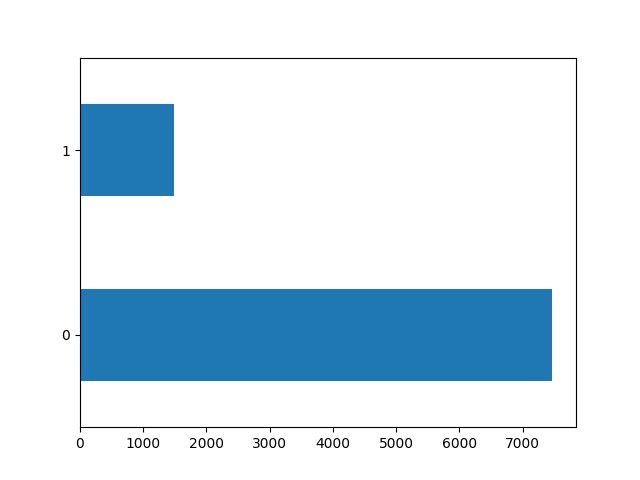

In [46]:
plt.figure()
train.target.value_counts().plot.barh()
plt.show()

# standardizing

In [47]:
sca = StandardScaler()

### city_development_index and training_hours

In [48]:
train.loc[:, ["city_development_index", "training_hours"]] = sca.fit_transform(train.loc[:, ["city_development_index", "training_hours"]])

# DUMMY 1ST MODEL

In [49]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score


In [50]:
X = train.drop("target", axis=1)
y = train.target

In [51]:
folds = 10

In [52]:
skf = StratifiedKFold(n_splits=folds)
skf.get_n_splits(X, y)

10

In [53]:
def run_kfold(X, y, model, folds=10):
    skf = StratifiedKFold(n_splits=folds)
    skf.get_n_splits(X, y)
    roc_auc_avg = 0
    k = 0
    for train_index, test_index in skf.split(X, y):
        k+=1
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        
        roc_auc_avg += roc_auc_score(y_pred, y_test)

      
        print("\nfold " + str(k) + " " + str(roc_auc_score(y_pred, y_test)))
        print('Accuracy: %f, \nRecall: %f \nPrecision: %f'
          % (accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)))



    print("avg roc_auc score is " + str(roc_auc_avg/k))
    

In [54]:
lg = linear_model.LogisticRegression(max_iter=3000)
run_kfold(X, y, lg, folds=10)


fold 1 0.7861582861582861
Accuracy: 0.867188, 
Recall: 0.358108 
Precision: 0.688312

fold 2 0.7497653973428162
Accuracy: 0.859375, 
Recall: 0.418919 
Precision: 0.607843

fold 3 0.7377136752136753
Accuracy: 0.853795, 
Recall: 0.409396 
Precision: 0.586538

fold 4 0.7410548602030015
Accuracy: 0.854911, 
Recall: 0.402685 
Precision: 0.594059

fold 5 0.7144014929352173
Accuracy: 0.843750, 
Recall: 0.436242 
Precision: 0.537190

fold 6 0.71667631731326
Accuracy: 0.845810, 
Recall: 0.405405 
Precision: 0.545455

fold 7 0.7367968891300416
Accuracy: 0.853631, 
Recall: 0.385135 
Precision: 0.587629

fold 8 0.7294774008102665
Accuracy: 0.851397, 
Recall: 0.432432 
Precision: 0.566372

fold 9 0.7008094498564639
Accuracy: 0.839106, 
Recall: 0.378378 
Precision: 0.518519

fold 10 0.7529530978575565
Accuracy: 0.861453, 
Recall: 0.452703 
Precision: 0.609091
avg roc_auc score is 0.7365806866820586


In [55]:
rfc = RandomForestClassifier(random_state=0)
run_kfold(X, y, rfc, folds=10)


fold 1 0.763421285034783
Accuracy: 0.860491, 
Recall: 0.344595 
Precision: 0.645570

fold 2 0.7331528920335877
Accuracy: 0.851562, 
Recall: 0.344595 
Precision: 0.586207

fold 3 0.7417304230423043
Accuracy: 0.853795, 
Recall: 0.355705 
Precision: 0.602273

fold 4 0.7270089395959894
Accuracy: 0.849330, 
Recall: 0.389262 
Precision: 0.568627

fold 5 0.7102083333333333
Accuracy: 0.842634, 
Recall: 0.348993 
Precision: 0.541667

fold 6 0.7285573883709193
Accuracy: 0.850279, 
Recall: 0.364865 
Precision: 0.574468

fold 7 0.7523308630169735
Accuracy: 0.859218, 
Recall: 0.391892 
Precision: 0.617021

fold 8 0.7165506851280581
Accuracy: 0.845810, 
Recall: 0.391892 
Precision: 0.547170

fold 9 0.7138665068168512
Accuracy: 0.844693, 
Recall: 0.331081 
Precision: 0.550562

fold 10 0.7360338678704142
Accuracy: 0.853631, 
Recall: 0.398649 
Precision: 0.584158
avg roc_auc score is 0.7322861184243215


# running with PCA

In [56]:
pca = PCA(random_state=0)
X_pca = pca.fit_transform(X)

In [57]:
X_pca

array([[-9.45667421e+02, -4.21592226e+00, -8.67832757e-01, ...,
        -1.45086875e-02,  8.51480092e-04,  3.30263589e-03],
       [-9.36664774e+02, -1.00752899e+01, -1.24277550e+00, ...,
         3.99037831e-04,  1.25058509e-02,  4.77482033e-03],
       [-9.18669173e+02, -2.15909714e+00, -2.79239118e+00, ...,
        -6.22236455e-05,  2.04937713e-02, -1.22518821e-03],
       ...,
       [-5.73669363e+02,  1.05737884e+00, -2.32554648e-02, ...,
        -9.28930878e-02,  2.99954379e-02, -1.05865044e-02],
       [ 1.45132778e+03,  5.33479414e+00, -2.86875113e+00, ...,
        -8.26058596e-02,  1.00617634e-02, -3.45032684e-02],
       [ 1.45133507e+03, -8.91504402e+00, -2.08778918e+00, ...,
        -2.40842576e-03,  3.77719190e-03, -6.00035944e-03]])

In [58]:
pca.explained_variance_ratio_

array([9.99936569e-01, 5.22375600e-05, 5.19321022e-06, 2.49862751e-06,
       1.10305054e-06, 9.14800479e-07, 3.88123781e-07, 3.06031406e-07,
       2.28561205e-07, 1.35506299e-07, 1.06060180e-07, 9.47612251e-08,
       7.19610581e-08, 5.10158861e-08, 3.33831597e-08, 2.13215846e-08,
       1.53581193e-08, 1.39025811e-08, 8.62515083e-09, 5.93171189e-09,
       2.79532342e-09])

In [59]:
pca.components_[0]

array([ 9.99999761e-01,  2.85224632e-04,  8.22518502e-07, -5.19433475e-05,
       -5.96037372e-05,  4.72747592e-04,  3.83330791e-04,  1.30525916e-04,
        1.32619421e-06, -2.00715753e-05,  8.09215448e-07,  6.54528381e-06,
        1.98267721e-05, -4.59572684e-07,  3.48670428e-06, -3.93903567e-05,
        9.46913472e-06,  1.13441962e-05,  3.81520049e-06, -1.61083742e-06,
       -1.53131247e-05])

In [60]:
print(np.shape(X))
print(np.shape(pca.components_[0]))

(8955, 21)
(21,)


<IPython.core.display.Javascript object>


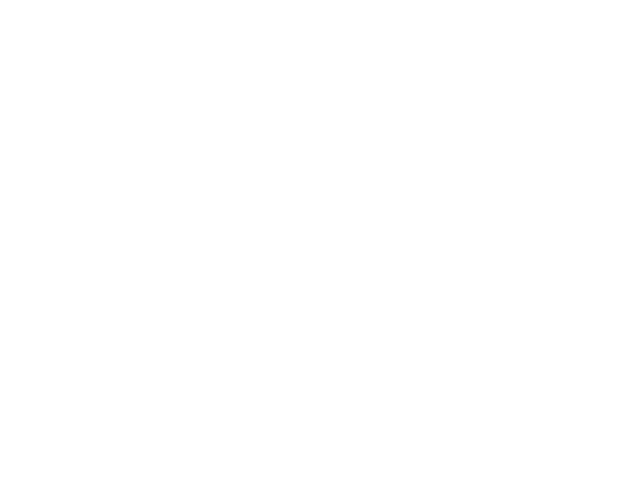

<IPython.core.display.Javascript object>


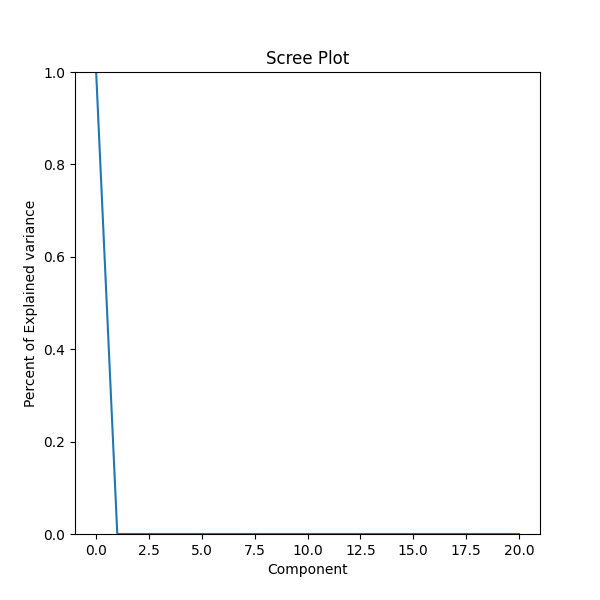

In [61]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pca.explained_variance_ratio_)

ax.set(xlabel="Component", ylabel="Percent of Explained variance", title="Scree Plot", ylim=(0,1))

plt.savefig("pca.png")
plt.show()

# RFE

In [62]:
rfe = RFE(rfc)

In [63]:
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(random_state=0))

In [64]:
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  2, 11,  9,  7, 12, 10,  3,  4,
        6,  8,  5,  1])

In [65]:
rfe.estimator_.n_features_

10

In [66]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [67]:
rfe_cols = X.columns[rfe.support_]

In [68]:
rfe_cols

Index(['city', 'city_development_index', 'relevent_experience',
       'enrolled_university', 'education_level', 'experience', 'company_size',
       'last_new_job', 'training_hours', 'company_type_Pvt Ltd'],
      dtype='object')

In [69]:
X_rfe = X.loc[:, rfe_cols]

In [70]:
lg = linear_model.LogisticRegression(max_iter=3000)
run_kfold(X_rfe, y, lg, folds=10)


fold 1 0.7809257003654081
Accuracy: 0.864955, 
Recall: 0.344595 
Precision: 0.680000

fold 2 0.7447236180904523
Accuracy: 0.857143, 
Recall: 0.405405 
Precision: 0.600000

fold 3 0.7564264643910662
Accuracy: 0.861607, 
Recall: 0.436242 
Precision: 0.619048

fold 4 0.7461158927019185
Accuracy: 0.857143, 
Recall: 0.416107 
Precision: 0.601942

fold 5 0.716709621993127
Accuracy: 0.844866, 
Recall: 0.436242 
Precision: 0.541667

fold 6 0.7322235089751014
Accuracy: 0.852514, 
Recall: 0.425676 
Precision: 0.572727

fold 7 0.7372368421052632
Accuracy: 0.853631, 
Recall: 0.378378 
Precision: 0.589474

fold 8 0.7318511796733213
Accuracy: 0.852514, 
Recall: 0.445946 
Precision: 0.568966

fold 9 0.7136720667648502
Accuracy: 0.844693, 
Recall: 0.358108 
Precision: 0.546392

fold 10 0.732602769208695
Accuracy: 0.852514, 
Recall: 0.412162 
Precision: 0.575472
avg roc_auc score is 0.7392487664269203


In [71]:
rfc = RandomForestClassifier(random_state=0)
run_kfold(X_rfe, y, rfc, folds=10)


fold 1 0.759313725490196
Accuracy: 0.859375, 
Recall: 0.344595 
Precision: 0.637500

fold 2 0.732202580028667
Accuracy: 0.851562, 
Recall: 0.358108 
Precision: 0.582418

fold 3 0.7376970855231725
Accuracy: 0.852679, 
Recall: 0.362416 
Precision: 0.593407

fold 4 0.7491356744209019
Accuracy: 0.858259, 
Recall: 0.416107 
Precision: 0.607843

fold 5 0.7077216910099291
Accuracy: 0.841518, 
Recall: 0.369128 
Precision: 0.533981

fold 6 0.7195723684210525
Accuracy: 0.846927, 
Recall: 0.358108 
Precision: 0.557895

fold 7 0.7471943038132529
Accuracy: 0.858101, 
Recall: 0.412162 
Precision: 0.603960

fold 8 0.7141478212906784
Accuracy: 0.844693, 
Recall: 0.405405 
Precision: 0.540541

fold 9 0.713712995984737
Accuracy: 0.844693, 
Recall: 0.371622 
Precision: 0.544554

fold 10 0.7288903026693379
Accuracy: 0.850279, 
Recall: 0.358108 
Precision: 0.576087
avg roc_auc score is 0.7309588548651925
